<a href="https://colab.research.google.com/github/nawroz-m/ML_learning/blob/main/04_transfer_learning_with_tensorflow_feature_extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Transfer Learning with Tensorflow part 1: Feature Extraction
Transfer Learning is leveraging a working model's existing architecture and learn pattern for our own problem.
There are two main benefits:

1. Can leverage an existing Neural Network architecture proven to work on problem similar to our own.
2. Can leverage working Neural Network architecture which has already learned patterns on similar data to our own, then we can adapt those patern to our own data

In [1]:
# Are we using GPU
!nvidia-smi

Mon Oct 27 04:40:10 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   57C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## Download the data

In [2]:
!wget https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip

--2025-10-27 04:40:10--  https://storage.googleapis.com/ztm_tf_course/food_vision/10_food_classes_10_percent.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 192.178.163.207, 173.194.202.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 168546183 (161M) [application/zip]
Saving to: ‘10_food_classes_10_percent.zip’

10_food_classes_10_ 100%[===================>] 160.74M   157MB/s    in 1.0s    

2025-10-27 04:40:12 (157 MB/s) - ‘10_food_classes_10_percent.zip’ saved [168546183/168546183]



In [3]:
import zipfile
import os

In [4]:
# unzip the file
zip_ref = zipfile.ZipFile('10_food_classes_10_percent.zip')
zip_ref.extractall()
zip_ref.close()

In [5]:
# Check all the files and folders
dataset_dir = '10_food_classes_10_percent'
for dirpath, dirnames, filenames in os.walk(dataset_dir):
  print(f"There are {len(dirnames)} directories and {len(filenames)} images in {dirpath}")

There are 2 directories and 0 images in 10_food_classes_10_percent
There are 10 directories and 0 images in 10_food_classes_10_percent/test
There are 0 directories and 250 images in 10_food_classes_10_percent/test/pizza
There are 0 directories and 250 images in 10_food_classes_10_percent/test/steak
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ice_cream
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_curry
There are 0 directories and 250 images in 10_food_classes_10_percent/test/chicken_wings
There are 0 directories and 250 images in 10_food_classes_10_percent/test/sushi
There are 0 directories and 250 images in 10_food_classes_10_percent/test/ramen
There are 0 directories and 250 images in 10_food_classes_10_percent/test/hamburger
There are 0 directories and 250 images in 10_food_classes_10_percent/test/grilled_salmon
There are 0 directories and 250 images in 10_food_classes_10_percent/test/fried_rice
There are 10 directori

In [6]:
import pathlib
import numpy as np

In [7]:
# Get classes
root_dir = pathlib.Path(os.path.join(dataset_dir, 'train'))
class_names = np.array(sorted([item.name for item in root_dir.glob('*')]))
class_names

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [8]:
# Another way to get the classes
np.array(sorted(os.listdir(os.path.join(dataset_dir, 'train'))))

array(['chicken_curry', 'chicken_wings', 'fried_rice', 'grilled_salmon',
       'hamburger', 'ice_cream', 'pizza', 'ramen', 'steak', 'sushi'],
      dtype='<U14')

In [9]:
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

(np.float64(-0.5), np.float64(383.5), np.float64(511.5), np.float64(-0.5))

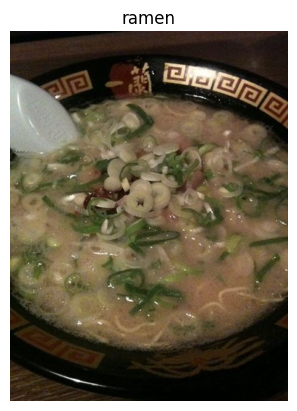

In [10]:
# plot a random image from a random class
# get a random class
random_class = random.choice(class_names)
# get a ranom image
images = os.listdir(os.path.join(dataset_dir, 'train', random_class))
random_image = random.choice(images)
# Get image data
img = mpimg.imread(os.path.join(dataset_dir, 'train', random_class, random_image))
#plot the image
plt.imshow(img)
plt.title(random_class)
plt.axis(False)

# Creating the data loader(Preparing the data)
Will use the `imageDataGenerator` to load the images in batches


In [11]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [12]:
# Get the dataset generator
train_datagen = ImageDataGenerator(rescale=1/255.0)
test_datgen = ImageDataGenerator(rescale=1/255.0)

In [13]:
train_dir = os.path.join(dataset_dir, 'train')
test_dir = os.path.join(dataset_dir, 'test')

In [14]:
# Prepare the dataset
train_data = train_datagen.flow_from_directory(train_dir, target_size=(224, 224),
                                               class_mode='categorical',
                                               batch_size=32,
                                               shuffle=True,
                                               seed=42)
test_data =test_datgen.flow_from_directory(test_dir,
                                           target_size=(224,224),
                                           class_mode='categorical',
                                           batch_size=32,
                                           shuffle=True,
                                           seed=42)

Found 750 images belonging to 10 classes.
Found 2500 images belonging to 10 classes.


In [15]:
image, labels = next(train_data)
image[0].shape, labels[0].shape, len(train_data), len(test_data), 750/32

((224, 224, 3), (10,), 24, 79, 23.4375)

## Setting up callbacks (things to run while a model train)
Callbacks are extra functionality you can add to you models to be perfomed during or after training. Popular callbacks
* Tracking experiment with TensoreBoard callback
* Model checkpointing with ModelCheckPoint callback
* Stopping a model from training(before it train too long and overfitting) with EarlyStopping callback

In [16]:
from tensorflow.keras.callbacks import TensorBoard

In [17]:
# Create a TensorBoard callback
import datetime
def create_tensorbaord_callback(dir_name, experiment_name):
    log_dir = os.path.join(dir_name, experiment_name, datetime.datetime.now().strftime("%Y-%m-%d-%H%M%S"))
    tensor_board_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir)
    return tensor_board_callback

# Creating a model using Tensorflow Hub

In [18]:
import tensorflow_hub as hub
model = hub.KerasLayer("https://tfhub.dev/google/nnlm-en-dim128/2")


In [19]:
embeddings = model(["The rain in Spain.", "falls",
                      "mainly", "In the plain!"])
embeddings.shape

TensorShape([4, 128])